In [19]:
# Magpylib documentation 
# Running v4.2, but that documentaiton is somewhat incomplete on the basics.  
# See doc v. 2.3 for additional details.
# doc v4.2: https://magpylib.readthedocs.io/en/latest/
# doc v2.3: https://magpylib.readthedocs.io/en/2.3.0-beta/_pages/0_documentation/

# Additional module for calculating forces
# https://github.com/MateusRodolfo/magforce

from __future__ import annotations

import numpy as np
import magpylib as magpy
from kicad_phase_coil import *
from pint import Quantity as Q
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('dark_background')

In [20]:
# Generate PCB geometry via KiCAD Coil package
# Code per micro-motor-proto-1.py
coil = SectorCoil()
coil.dia_inside = 2
coil.dia_outside = coil.dia_inside + 18
coil.width = Q(6e-3, "in").to("mm").magnitude  # mils to mm.
coil.spacing = Q(6e-3, "in").to("mm").magnitude  # mils to mm.
coil.Generate()
pts = coil.ToNumpy(n=5)

# The SectorCoil outputs a list of x & y coords, but MagPy needs a Z coord.
pts = np.array([pts[0],pts[1],pts[0]*0]).transpose()

# Create MagPy version of the coil
trace_top = magpy.current.Line(current=1.0, vertices=list(pts),style_label='Top')
trace_bot = magpy.current.Line(current=1.0, vertices=list(pts),position=[0,0,-1.6],style_label='Bottom')


In [21]:
# Permanent magnet
B_n52 = 400 # https://www.kjmagnetics.com/calculator.asp for cylinder magnet.
mag = magpy.magnet.Cylinder(magnetization=[0,0,B_n52],
                            dimension=[6,2],
                            position=[4,2,1.1])

/usr/local/lib/python3.8/dist-packages/magpylib/_src/display/traces_utility.py:95: RuntimeWarning:

invalid value encountered in divide



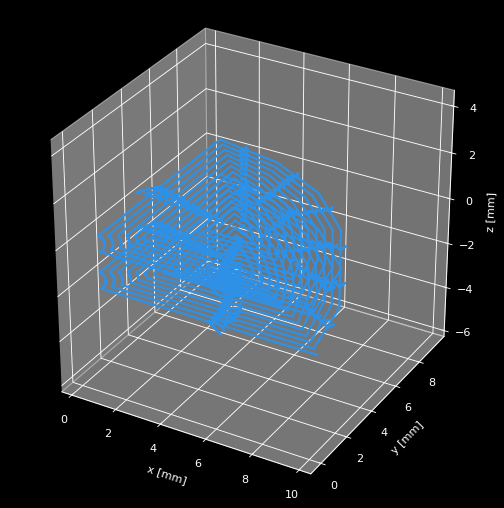

/usr/local/lib/python3.8/dist-packages/magpylib/_src/display/traces_utility.py:95: RuntimeWarning:

invalid value encountered in divide



In [22]:
# Put all magnetic elements into the system
# The magnet dominates the field
# A single coil at 1.0A is generating about 3 mT.
# The magnet is 2x orders of magnitude stronger
trace_top.parent = None
mag.parent = None
sys = magpy.Collection()
sys += trace_top
sys += trace_bot
# sys += mag
sys.show()


fig = go.Figure()
magpy.show(sys,canvas=fig,backend='plotly')
fig.write_html('temp.html')


In [23]:
# Range of points in to evaluate in each direction.
ndim = 3
npts = 10
x = np.linspace(-5,15,npts+11)
y = np.linspace(-5,15,npts+11)
z = np.linspace(-5,5,npts)
mesh = np.meshgrid(x,y,z)
points = np.array(mesh).T.reshape(-1,ndim)

# Get the vector field at each point.
Bvect = magpy.getB(sys,points)

In [30]:
# Create a cone plot.
fig = go.Figure()
magpy.show(sys,canvas=fig,backend='plotly')
trc = go.Cone(x=points[:,0],y=points[:,1],z=points[:,2],
              u=Bvect[:,0],v=Bvect[:,1],w=Bvect[:,2],
              colorscale='Blues',
              sizemode='absolute',
              opacity=0.5,
              sizeref=5)
fig.add_trace(trc)

# idx = np.arange(0,len(points),int(len(points)/100))
# trc = go.Streamtube(x=points[:,0],y=points[:,1],z=points[:,2],
#               u=Bvect[:,0],v=Bvect[:,1],w=Bvect[:,2],
#               showscale=False,
#               colorscale='Blues',
#               maxdisplayed=500,
#               sizeref=0.2,
#               starts = dict(x=points[idx,0],y=points[idx,1],z=points[idx,2]*0))
# fig.add_trace(trc)

s_npts = 5
s_x = np.linspace(3,6,s_npts)
s_y = np.linspace(3,6,s_npts)
s_mesh = np.meshgrid(s_x,s_y)
s_points = np.array(s_mesh).T.reshape(-1,2)

trc = go.Streamtube(x=points[:,0],y=points[:,1],z=points[:,2],
              u=Bvect[:,0],v=Bvect[:,1],w=Bvect[:,2],
              showscale=False,
              colorscale='Blues',
              maxdisplayed=100,
              sizeref=0.5,
              starts = dict(x=s_points[:,0],y=s_points[:,1],z=points[:,0]*0))
fig.add_trace(trc)


fig.write_html('b-field.html')